# Portfolio optimization using TMAI API

This notebook demonstrates optimal portfolio rebalancing of a basket of tokens tradable on the Aerodrome dex on the Base network.

It fetches market data using the TokenMetrics sdk and computes weights of the portfolio having the best sharpe ratio using Markowitz's efficient frontier model.

In [25]:
import tmai_api
import numpy as np
import pandas as pd

client = tmai_api.TokenMetricsClient(api_key="tm-82f00de8-1d92-41bc-9760-e58f4f56ecef")

In [26]:
tokens_df = client.tokens.get_dataframe(exchange="aerodrome-base")
# asset_names = tokens_df.head(10)['TOKEN_NAME'].astype(str)
asset_names = ['Bitcoin', 'Ethereum', 'Aerodrome Finance', 'USDC', 'yearn.finance', 'Dickbutt', 'KlimaDAO']

In [27]:
ohlcv = client.daily_ohlcv.get_dataframe(token_name=','.join(asset_names), startDate="2023-01-01", endDate="2025-01-01")

Fetching daily-ohlcv data: 100%|█████████████| 26/26 [00:50<00:00,  1.92s/chunk]


In [28]:
ohlcv

,TOKEN_ID,TOKEN_NAME,TOKEN_SYMBOL,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME
0,3306,Ethereum,ETH,2023-01-30T00:00:00.000Z,1648.840000,1648.840,1548.550000,1567.330000,1.097470e+10
1,3375,Bitcoin,BTC,2023-01-30T00:00:00.000Z,23826.120000,23826.120,22671.900000,22816.500000,3.831954e+10
2,3396,USDC,USDC,2023-01-30T00:00:00.000Z,1.000000,1.020,0.997090,1.000000,3.333475e+09
3,4253,yearn.finance,YFI,2023-01-30T00:00:00.000Z,7762.030000,7825.670,7075.920000,7163.010000,3.657490e+07
4,4253,yearn.finance,YFI,2023-01-29T00:00:00.000Z,7425.110000,7789.240,7398.330000,7759.240000,2.691401e+07
...,...,...,...,...,...,...,...,...,...
2537,30747,Aerodrome Finance,AERO,2024-12-26T00:00:00.000Z,1.620000,1.630,1.510000,1.520000,4.970263e+07
2538,3396,USDC,USDC,2024-12-26T00:00:00.000Z,0.999319,1.002,0.996935,1.001000,5.675460e+09
2539,2497,KlimaDAO,KLIMA,2024-12-26T00:00:00.000Z,1.029000,1.031,0.892925,0.908693,2.639411e+05
2540,3375,Bitcoin,BTC,2024-12-26T00:00:00.000Z,99006.000000,99345.000,95184.000000,95728.000000,4.805196e+10


In [80]:
data = ohlcv.copy()
data['DATE'] = pd.to_datetime(pd.to_datetime(data['DATE']).dt.date)
data = data.groupby(['DATE', 'TOKEN_NAME'])['CLOSE'].last().unstack().bfill()
assets = [asset for asset in asset_names if asset in data.columns]
data = data[assets]
data

TOKEN_NAME,Bitcoin,Ethereum,Aerodrome Finance,USDC,yearn.finance,KlimaDAO
DATE,,,,,,
2023-01-06,16969.12,1270.02,0.038638,1.000000,5475.62,2.690000
2023-01-07,16945.29,1263.67,0.038638,1.000000,5480.09,2.690000
2023-01-08,17056.14,1284.78,0.038638,1.000000,5665.61,2.690000
2023-01-09,17184.41,1320.97,0.038638,1.000000,5747.16,2.690000
2023-01-10,17441.38,1337.46,0.038638,1.000000,5881.74,2.690000
...,...,...,...,...,...,...
2024-12-28,95276.00,3410.29,1.550000,1.001000,8841.06,0.843901
2024-12-29,93210.00,3341.94,1.480000,0.998576,8275.68,0.816312
2024-12-30,92673.00,3357.01,1.410000,1.000000,8272.72,0.799065


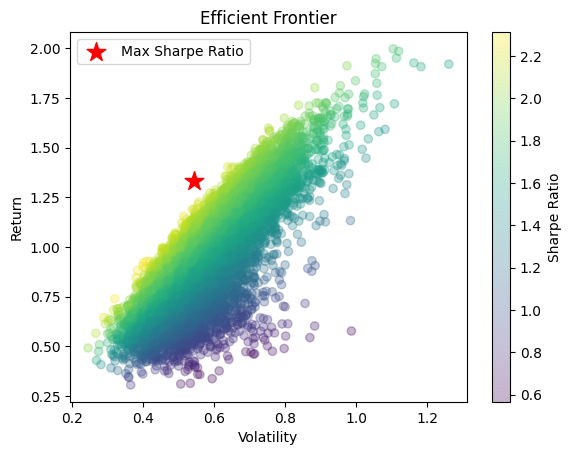

,Asset,Weight
0,Bitcoin,83.66%
1,Ethereum,0.00%
2,Aerodrome Finance,16.34%
3,USDC,0.00%
4,yearn.finance,0.00%
5,KlimaDAO,0.00%


In [129]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def calculate_annualized_returns(data):
    returns = data.pct_change().dropna()
    return returns.mean() * 252, returns.cov() * 252

def simulate_portfolios(mean_returns, cov_matrix, num_assets, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = portfolio_return / portfolio_volatility  # Sharpe ratio
    
    return results

def optimize_portfolio(mean_returns, cov_matrix, num_assets, *, method):
    def portfolio_performance(weights):
        returns = np.dot(weights, mean_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return returns, volatility
    
    def negative_sharpe_ratio(weights, risk_free_rate=0.02):
        returns, volatility = portfolio_performance(weights)
        return -(returns - risk_free_rate) / volatility
    
    def minimize_volatility(weights):
        _, volatility = portfolio_performance(weights)
        return volatility
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets]

    func = minimize_volatility if method == "min_variance" else negative_sharpe_ratio
    optimized = minimize(func, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    weights = optimized.x
    
    weights = np.round(weights, 4)
    weights[np.abs(weights) < 1e-3] = 0

    return weights

def plot_efficient_frontier(results, optimal_weights_sharpe, mean_returns, cov_matrix):
    optimal_return = np.dot(optimal_weights_sharpe, mean_returns)
    optimal_volatility = np.sqrt(np.dot(optimal_weights_sharpe.T, np.dot(cov_matrix, optimal_weights_sharpe)))    
    
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=200, label='Max Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('Efficient Frontier')
    plt.legend()
    plt.show()

def main(data, assets, *, method, plot=False):
    mean_returns, cov_matrix = calculate_annualized_returns(data)
    num_assets = len(assets)
    
    results = simulate_portfolios(mean_returns, cov_matrix, num_assets)
    optimal_weights = optimize_portfolio(mean_returns, cov_matrix, num_assets, method=method)
    
    if plot:
        plot_efficient_frontier(results, optimal_weights_sharpe, mean_returns, cov_matrix)
    
    return optimal_weights

weights = main(data, assets, method="max_sharpe", plot=True)
pd.DataFrame({'Asset': assets, 'Weight': [f"{w*100:.2f}%" for w in weights]})

In [124]:
window_size = 12 # months
start_dates = data.resample('MS').mean().index[:window_size] # Get valid start dates
start_dates

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')

In [205]:
all_weights = pd.DataFrame(columns=data.columns, index=data.index)
#all_weights.index.name = "Date"

for start in start_dates:
    end = start + pd.DateOffset(months=window_size)
    df = data.loc[start:end]
    
    if not rolling_window.empty:
        weights = main(df, assets, method="max_sharpe")
        d = pd.DataFrame({'Asset': assets, 'Weight': [f"{w*100:.2f}%" for w in weights]})
        # print(start, end, [f"{w*100:.2f}%" for w in weights])
        print(start, end, weights)
        all_weights.loc[end, :] = weights

all_weights = all_weights.sort_index().loc[start_dates[0]+pd.DateOffset(months=window_size):]

2023-01-01 00:00:00 2024-01-01 00:00:00 [0.847 0.    0.153 0.    0.    0.   ]
2023-02-01 00:00:00 2024-02-01 00:00:00 [0.7228 0.     0.2772 0.     0.     0.    ]
2023-03-01 00:00:00 2024-03-01 00:00:00 [0.8396 0.     0.1604 0.     0.     0.    ]
2023-04-01 00:00:00 2024-04-01 00:00:00 [0.802  0.     0.1648 0.     0.     0.0332]
2023-05-01 00:00:00 2024-05-01 00:00:00 [0.7163 0.     0.1636 0.     0.     0.1201]
2023-06-01 00:00:00 2024-06-01 00:00:00 [0.7378 0.     0.1432 0.     0.     0.119 ]
2023-07-01 00:00:00 2024-07-01 00:00:00 [0.7003 0.     0.1529 0.     0.     0.1468]
2023-08-01 00:00:00 2024-08-01 00:00:00 [0.7125 0.     0.1519 0.     0.     0.1356]
2023-09-01 00:00:00 2024-09-01 00:00:00 [0.7802 0.     0.1546 0.     0.     0.0652]
2023-10-01 00:00:00 2024-10-01 00:00:00 [0.7602 0.     0.1772 0.     0.     0.0626]
2023-11-01 00:00:00 2024-11-01 00:00:00 [0.719  0.     0.2003 0.     0.     0.0808]
2023-12-01 00:00:00 2024-12-01 00:00:00 [0.7751 0.     0.195  0.     0.     0.0299

In [206]:
import vectorbt as vbt

close = data.reindex(all_weights.index)
pf = vbt.Portfolio.from_orders(
    close=close.astype(float),
    size=all_weights.astype(float),
    size_type='targetpercent',
    init_cash=1000,
    cash_sharing=True,
    group_by=True,
    call_seq="auto",
    fees=None,
)

Total profit: 4320.137299307343


/Users/axel/.pyenv/versions/3.10.12/lib/python3.10/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

/Users/axel/.pyenv/versions/3.10.12/lib/python3.10/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



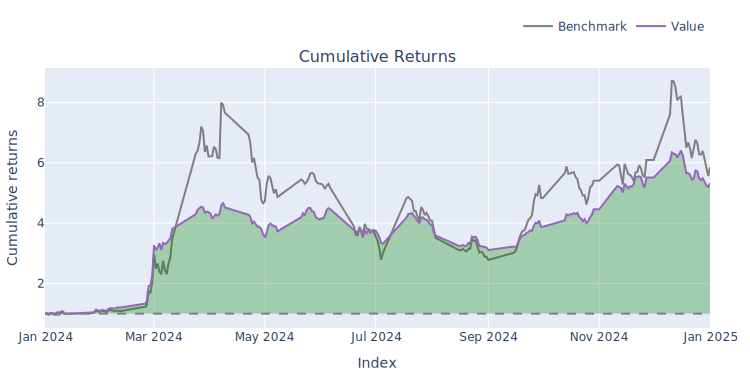

In [209]:
print("Total profit:", pf.total_profit())
pf.plot().show_svg()

/Users/axel/.pyenv/versions/3.10.12/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/Users/axel/.pyenv/versions/3.10.12/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



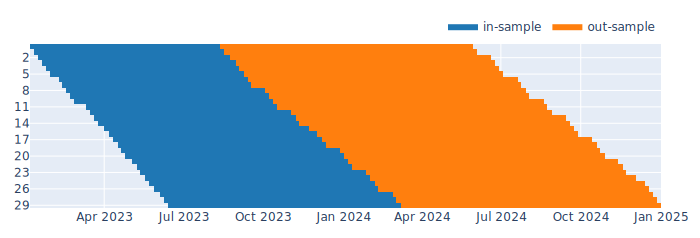

In [216]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

split_kwargs = dict(
    n=30, 
    window_len=365, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

price = pf.asset_value()
roll_in_and_out_samples(data, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [220]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(data, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample



def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()



in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)




(185, 180) 30
(180, 180) 30
